In [1]:
import os
import os.path
from os import path

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from sklearn.metrics import roc_curve,roc_auc_score
from datetime import datetime,timedelta
import wandb
from GenericTools import *
from TripletLossTools import *
from QuadrupletLossTools import *


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
mnist = tf.keras.datasets.mnist

# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
projectName = "27_mnist_10_mining"
project_path = './{0}/'.format(projectName)
model_path = '../azurenb_temp/{0}/'.format(projectName)
if not path.exists(project_path):
    os.mkdir(project_path)
if not path.exists(model_path):
    os.mkdir(model_path)  

## Dataset


In [3]:
nb_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = mnist.load_data()

    assert K.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
        
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin



Checking shapes for class 0 (train) :  (5923, 28, 28, 1)
Checking shapes for class 0 (test) :  (980, 28, 28, 1)
Checking first samples


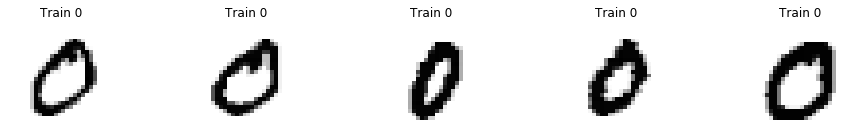

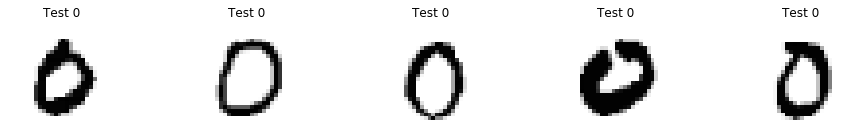

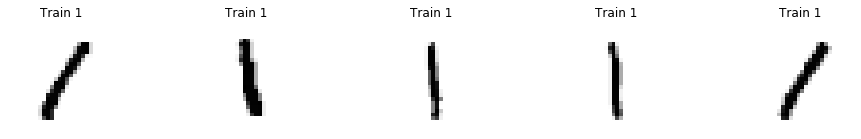

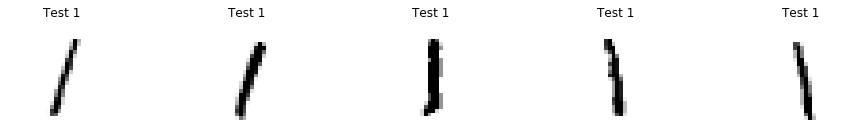

In [4]:
dataset_train,dataset_test,dataset_train_flat_X,dataset_train_flat_Y,dataset_test_flat_X,dataset_test_flat_Y = buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking first samples")
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

### Build Neural Network for computing triplet similarity

In [5]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''

    # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',padding='same',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',padding='same',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

In [6]:
alpha1=1
alpha2=0.5
embeddingsize=10
nb_test_class=10

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10)           51874442    anchor_input[0][0]               
                                                                 positive_input[0][0]         

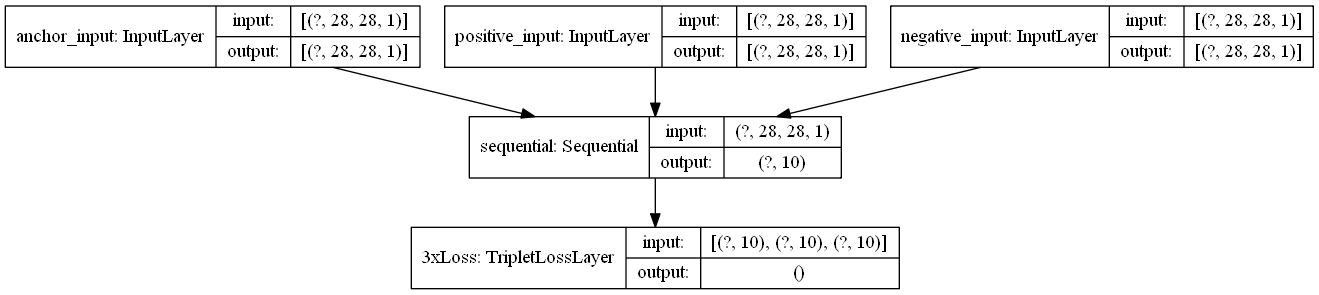

In [7]:
#modele en 3xloss
network3 = build_network(input_shape,embeddingsize=embeddingsize)
network3_train = build_model3(input_shape,network3,margin=alpha1)
optimizer3 = Adam(lr = 0.00006)
network3_train.compile(loss=None,optimizer=optimizer3)
network3_train.summary()
plot_model(network3_train,show_shapes=True, show_layer_names=True, to_file=project_path+'model_summary_3x.png')

In [8]:
def build_metric_network(single_embedding_shape):
    '''
    Define the neural network to learn the metric
    Input : 
            single_embedding_shape : shape of input embeddings or feature map. Must be an array
            
    '''
    #compute shape for input
    input_shape = single_embedding_shape
    #the two input embeddings will be concatenated    
    input_shape[0] = input_shape[0]*2
    
     # Neural Network
    network = Sequential(name="learned_metric")
    network.add(Dense(10, activation='relu',
                   input_shape=input_shape, 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    network.add(Dense(10, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))  
    network.add(Dense(10, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Last layer : binary softmax
    network.add(Dense(2, activation='softmax'))
    
    #Select only one output value from the softmax
    network.add(Lambda(lambda x: x[:,0]))
    
    return network


In [9]:
#modele en 4xloss
network4 = build_network(input_shape,embeddingsize=10)
network4.set_weights(network3.get_weights()) #copy weights to have identical networks
metric_network4 = build_metric_network(single_embedding_shape=[10])
network4_train = build_model4(input_shape,network4,metric_network4,margin=alpha1, margin2=alpha2)
optimizer4 = Adam(lr = 0.00006)
network4_train.compile(loss=None,optimizer=optimizer4)
network4_train.summary()
plot_model(network4_train,show_shapes=True, show_layer_names=True, to_file=project_path+'model_summary_4x.png')

n_iteration=0

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative2_input (InputLayer)    [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

![alt text](25_mnist_10/model_summary_4x.png " ")

In [10]:
#testing our NN with dummy image
featured_img = network4.predict(np.ones((1,img_rows,img_cols,1)))
print(featured_img)

[[-0.07986476  0.16704349  0.580824    0.19283454  0.1799758  -0.3376034
   0.4927724  -0.02770547  0.24476843 -0.37590575]]


### Preparing batch for training


Checking batch width, should be 4 :  4
Shapes in the batch A:(2, 28, 28, 1) P:(2, 28, 28, 1) N:(2, 28, 28, 1) N2:(2, 28, 28, 1)
Shapes in the hardbatch 4x A:(2, 28, 28, 1) P:(2, 28, 28, 1) N:(2, 28, 28, 1)


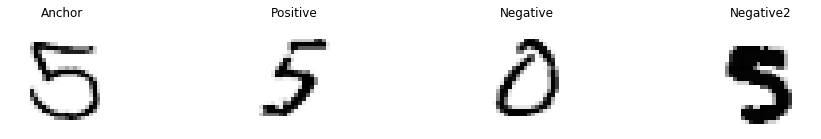

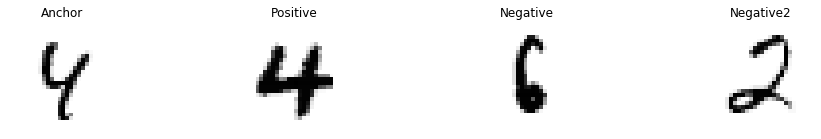

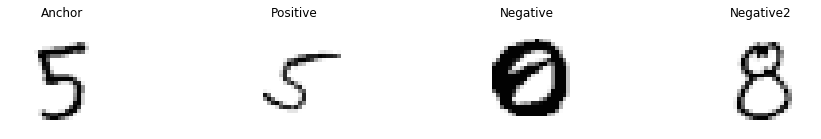

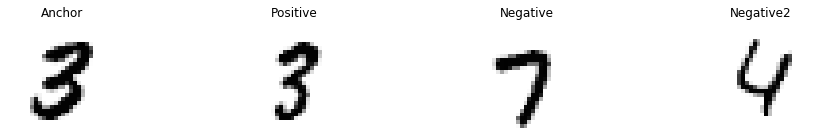

In [11]:
quadruplets = get_batch_random(2,dataset_train)
print("Checking batch width, should be 4 : ",len(quadruplets))
print("Shapes in the batch A:{0} P:{1} N:{2} N2:{3}".format(quadruplets[0].shape, quadruplets[1].shape, quadruplets[2].shape, quadruplets[3].shape))
drawQuadriplets(quadruplets)
hardtriplets,hardquadruplets = get_batch_hard(50,1,1,network3,network4,metric_network4,dataset_train)
print("Shapes in the hardbatch 4x A:{0} P:{1} N:{2}".format(hardquadruplets[0].shape, hardquadruplets[1].shape, hardquadruplets[2].shape, hardquadruplets[3].shape))
drawQuadriplets(hardquadruplets)

### Validation / evaluation



In [22]:
def draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, name1, name2, namewandb, savewandb=False):
    #find threshold
    targetfpr=1e-3
    _, idx1 = find_nearest(fpr1,targetfpr)
    threshold1 = thresholds1[idx1]
    recall1 = tpr1[idx1]
    _, idx2 = find_nearest(fpr2,targetfpr)
    threshold2 = thresholds2[idx2]
    recall2 = tpr2[idx2]
    
    fig=plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr1, tpr1, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc1,targetfpr,recall1,abs(threshold1),n_iteration,name1 ))
    
    subplot = fig.add_subplot(1,2,2)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr2, tpr2, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc2,targetfpr,recall2,abs(threshold2),n_iteration,name2 ))
    
    # show the plot
    fig.show()
    
    if savewandb:
        wandb.log({"Evaluation @ {0} iterations ({1})".format(n_iteration,namewandb):wandb.Image(fig)})
        print("saved")
    
def draw_embeddings(network):
    basepredict = network.predict(basepicture)
    plt.scatter(basepredict[:,0],basepredict[:,1])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    for i in range(4):
        plt.annotate(i, (basepredict[i,0], basepredict[i,1]))

    for i in range(4):
        preds = network.predict(dataset_test[i])
        plt.scatter(preds[:,0],preds[:,1])
        
def draw_embeddings_dual(network1, network2, savewandb=False):
    fig = plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    subplot.set_xlim([-11, 11])
    subplot.set_ylim([-11, 11])

    for i in range(nb_classes):
        preds = network1.predict(dataset_test[i])
        subplot.scatter((i+1)*preds[:,0],(i+1)*preds[:,1])
        
    subplot = fig.add_subplot(1,2,2)   
    subplot.set_xlim([-11, 11])
    subplot.set_ylim([-11, 11])

    for i in range(nb_classes):
        preds = network2.predict(dataset_test[i])
        subplot.scatter((i+1)*preds[:,0],(i+1)*preds[:,1])
        
    if savewandb:
        wandb.log({"Embeddings @{0} iterations".format(n_iteration):wandb.Image(fig)})
        
def draw_eval(network,n_iteration):
    probs,yprob = compute_probs(network, metricnetwork,dataset_test_flat_X,dataset_test_flat_Y)
    fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr,thresholds,auc,n_iteration)
    draw_embeddings(network)
    draw_interdist(network,n_iteration)
    
def draw_eval_dual(network1,network2,metricnetwork2,n_iteration,savewandb=False):
    interdistnbclass = 10
    interdistnbsample = 300
    probs_nbsamples = interdistnbclass*interdistnbsample
    
    t_start=time.time()
    #Computing probs for 3x
    probs1,yprob1 = compute_cache("probs3x", lambda :compute_probs(network1, dataset_test_flat_X[:probs_nbsamples,:,:,:],dataset_test_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)
    probs1train,yprob1train = compute_cache("probs3x", lambda :compute_probs(network1, dataset_train_flat_X[:probs_nbsamples,:,:,:],dataset_train_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)
    
    #Computing probs for 4x
    probs2,yprob2 = compute_cache("probs4x", lambda :compute_probs3iVectorized(network2, metricnetwork2,dataset_test_flat_X[:probs_nbsamples,:,:,:],dataset_test_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)
    probs2train,yprob2train = compute_cache("probs4x", lambda :compute_probs3iVectorized(network2, metricnetwork2,dataset_train_flat_X[:probs_nbsamples,:,:,:],dataset_train_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)

    #Computing metrics for 3x
    fpr1, tpr1, thresholds1,auc1 = compute_cache("metric3x", lambda :compute_metrics(probs1,yprob1),\
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)
    fpr1train, tpr1train, thresholds1train,auc1train = compute_cache("metric3x", lambda :compute_metrics(probs1train,yprob1train), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)                                             
    
    #Computing metrics for 4x
    fpr2, tpr2, thresholds2,auc2 = compute_cache("metric4x", lambda :compute_metrics(probs2,yprob2),\
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)                         
    fpr2train, tpr2train, thresholds2train,auc2train = compute_cache("metric4x", lambda : compute_metrics(probs2train,yprob2train),\
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)                                                                                          
        
    draw_roc_dual(fpr1train, tpr1train,thresholds1train,auc1train,fpr2train, tpr2train,thresholds2train,auc2train,n_iteration, "Triplet (Train)", "Quadruplet (Train)", savewandb)
    draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, "Triplet (Test)", "Quadruplet (Test)", savewandb)
    #draw_embeddings_dual(network1,network2, savewandb)

    draw_interdist(network1, n_iteration, dataset_train, savewandb, titleprefix="Triplet (Train)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    draw_interdist_learnedmetric(network2, metricnetwork2,n_iteration, dataset_train, savewandb, titleprefix="Quadruplet (Train)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    
    draw_interdist(network1, n_iteration, dataset_test, savewandb, titleprefix="Triplet (Test)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    draw_interdist_learnedmetric(network2, metricnetwork2,n_iteration, dataset_test, savewandb, titleprefix="Quadruplet (Test)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    elapsed_minute = (time.time()-t_start)/60
    
def compute_CMC_scores():
    #Compute CMC Scores
    cmc3x = compute_cache("cmc3x", lambda :ComputeCMCScoresL2(network3, dataset_test, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)
    cmc4x = compute_cache("cmc4x", lambda :ComputeCMCScoresLearnedMetric(network4, metric_network4, dataset_test, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)
    cmc3xtrain = compute_cache("cmc3xtrain", lambda :ComputeCMCScoresL2(network3, dataset_train, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)
    cmc4xtrain = compute_cache("cmc4xtrain", lambda :ComputeCMCScoresLearnedMetric(network4, metric_network4, dataset_train, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)

    cmc_dict ={
        '3x @ {0} iterations'.format(n_iteration): cmc3x ,
        '4x @ {0} iterations'.format(n_iteration): cmc4x,
        '3x @ {0} iterations (train)'.format(n_iteration): cmc3xtrain,
        '4x @ {0} iterations (train)'.format(n_iteration): cmc4xtrain}

    from CMC import CMC
    cmc = CMC(cmc_dict)

    #custimised color and marker
    new_color = ['r','g','r','g','m','y','orange','brown']
    new_marker = ['*','o','s','v','X','*','.','P']
    cmc = CMC(cmc_dict,color=new_color,marker=new_marker)
    #simple plot
    cmc.plot(title = 'CMC on MNIST ({0} test IDs)'.format(nb_test_class))

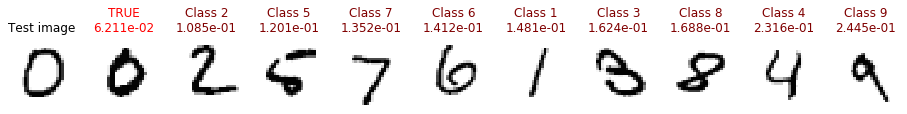

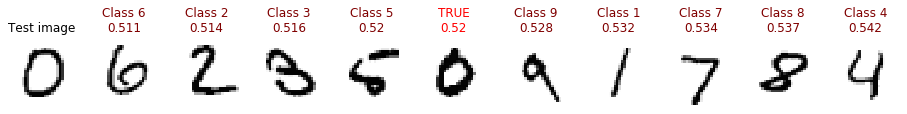

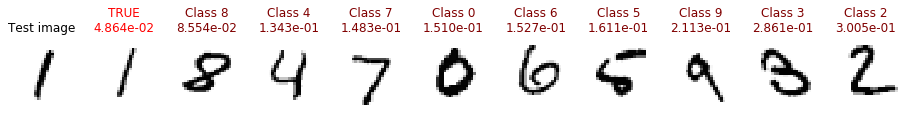

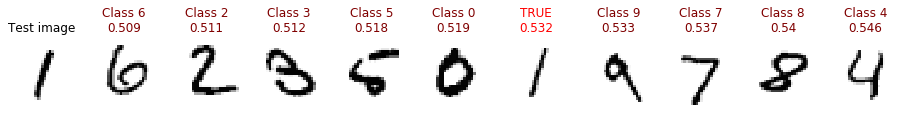

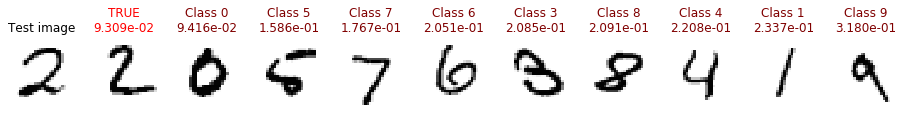

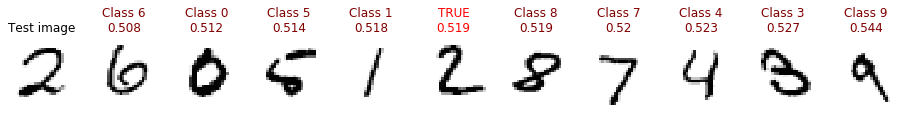

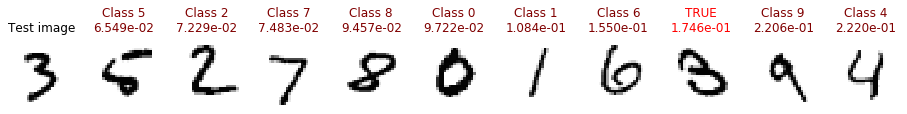

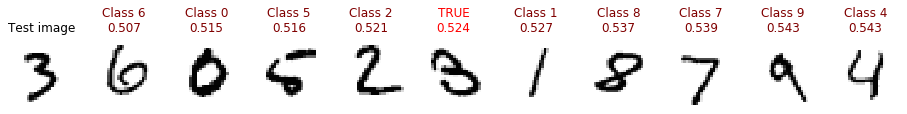

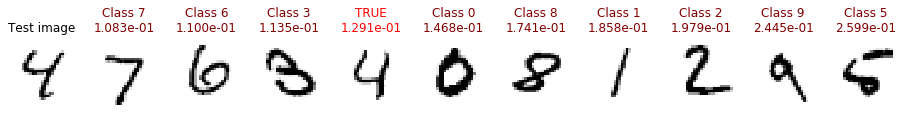

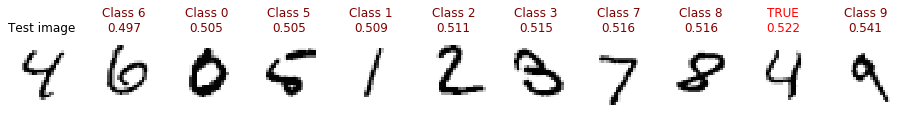

In [13]:

for i in range(5):
    DrawTestImageWithRank(network3,np.expand_dims(dataset_test[i][1,:,:,:],axis=0),dataset_test,threshold=abs(0), classindicator=i,nb_test_class=nb_test_class)
    DrawTestImageLearnedMetricWithRank(network4,metric_network4,np.expand_dims(dataset_test[i][1,:,:,:],axis=0),dataset_test,threshold=abs(0), classindicator=i,nb_test_class=nb_test_class)

Reloading cmc3x for n_iteration=0, nb_test_class=10, 
Reloading cmc4x for n_iteration=0, nb_test_class=10, 
Reloading cmc3xtrain for n_iteration=0, nb_test_class=10, 
Reloading cmc4xtrain for n_iteration=0, nb_test_class=10, 


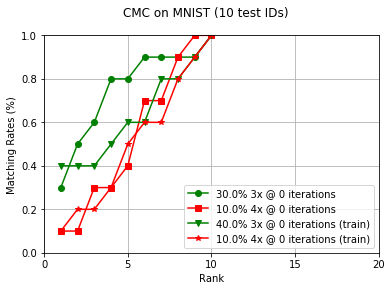

In [25]:
compute_CMC_scores()

### Training

In [14]:
def reloadFromIteration(n):
    global n_iteration
    n_iteration = n
    network3_train.load_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
    network4_train.load_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))

In [15]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
n_iter = 10000 # No. of training iterations
log_every = 50
sample_batch_size = 16

In [16]:
import wandb
wandb.init(project=projectName)
wandb.config.alpha1 = alpha1
wandb.config.alpha2 = alpha2
wandb.config.sample_batch_size = sample_batch_size
wandb.config.learningrate = K.eval(optimizer4.lr) 

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Computing probs for 3x
Computing probs3x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=test, 
Computing probs3x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=train, 
Computing probs for 4x
Computing probs4x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=test, 
Computing probs4x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=train, 
Computing metrics for 3x
Computing metric3x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=test, 
Computing metric3x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=train, 
Computing metrics for 4x
Computing metric4x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=test, 
Computing metric4x for n_iteration=0, interdistnbclass=10, interdistnbsample=600, dataset=train, 


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Computing L2 distance done                                  


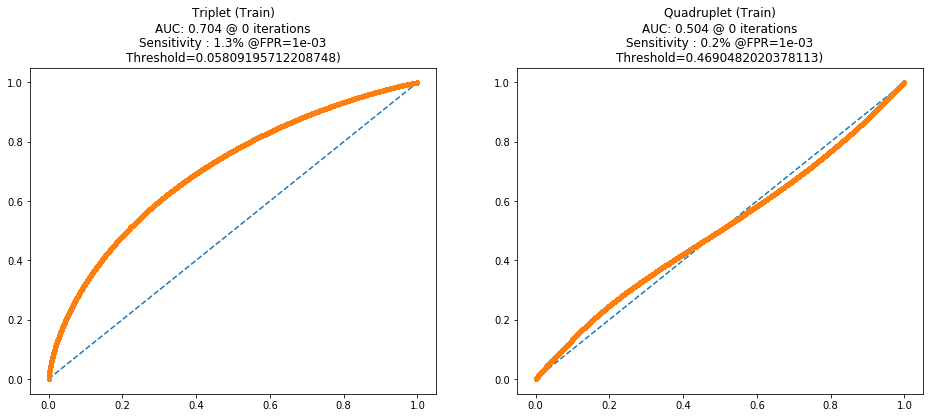

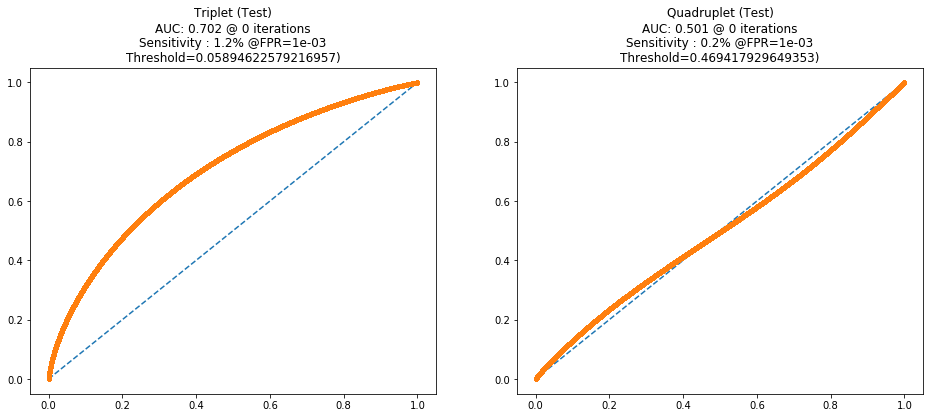

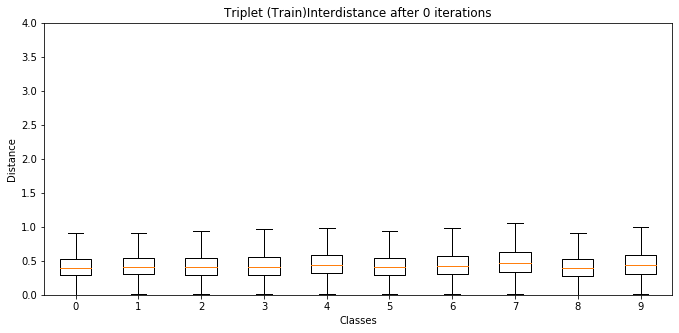

(32400000,)


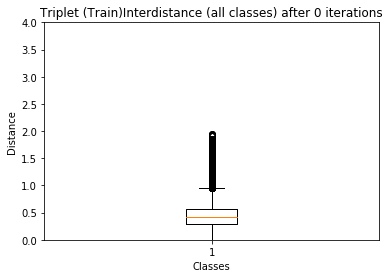

Computing learned distance done                                  


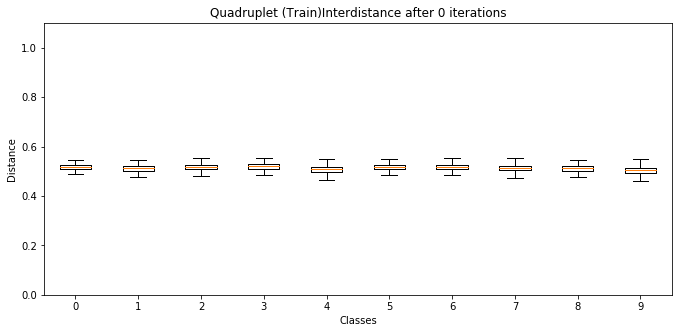

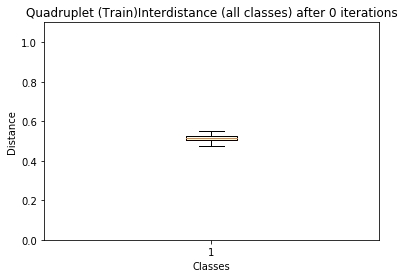

Computing L2 distance done                                  


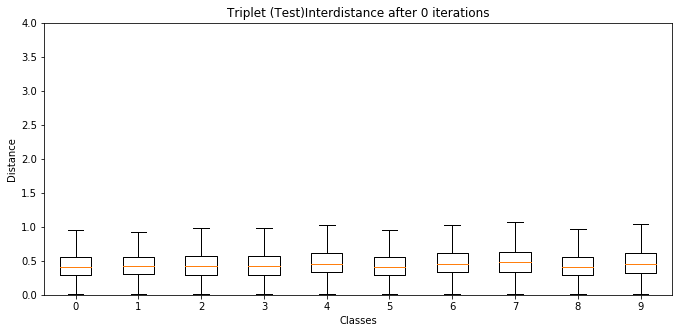

(32400000,)


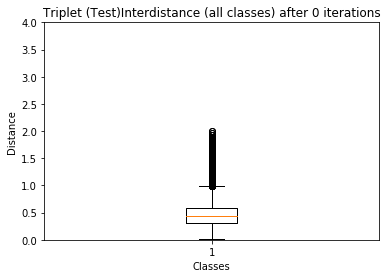

Computing learned distance done                                  


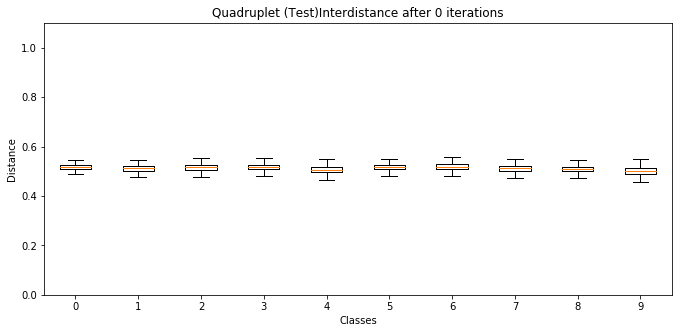

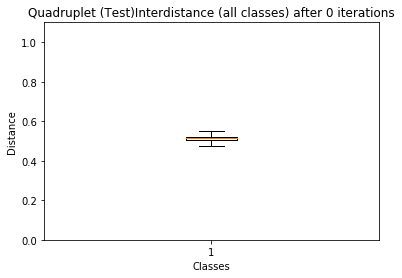

Evaluation time : 85.9430066784223 min


In [27]:
#Testing on an untrained network
draw_eval_dual(network3,network4,metric_network4,n_iteration,savewandb=False)

In [19]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    microtask_start =time.time() 
    triplets,quadruplets = get_batch_hardOptimized(100,16,16,network3,network4,metric_network4, dataset_train)
    timetogetbatch = time.time()-microtask_start
    microtask_start =time.time() 
    loss1 = network3_train.train_on_batch(triplets, None)
    timebatch3 = time.time()-microtask_start
    microtask_start =time.time() 
    loss2 = network4_train.train_on_batch(quadruplets, None)
    timebatch4 = time.time()-microtask_start
    n_iteration += 1
    if i % log_every == 0:
        wandb.log({'loss3x': loss1,'loss4x': loss2}, step=n_iteration)
    if i % evaluate_every == 0:
        elapsed_minutes = (time.time()-t_start)/60.0
        rate = i/elapsed_minutes 
        eta = datetime.now()+timedelta(minutes=(n_iter-i)/rate)
        eta = eta + timedelta(hours=0) #french time
        print("[{4}] iteration {0}: {1:.1f} iter/min, Train Loss: {2} {3}, eta : {5}".format(i, rate,loss1,loss2,n_iteration,eta.strftime("%Y-%m-%d %H:%M:%S") ))
        network3_train.save_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
        network4_train.save_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))      
#Final save
network3_train.save_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
network4_train.save_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))     
print("Done !")

Starting training process!
-------------------------------------


wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[11000] iteration 1000: 198.7 iter/min, Train Loss: 1.2947584390640259 6.960384845733643, eta : 2020-05-04 15:12:11
[12000] iteration 2000: 199.4 iter/min, Train Loss: 0.855588436126709 4.276537895202637, eta : 2020-05-04 15:12:01
[13000] iteration 3000: 199.7 iter/min, Train Loss: 0.8170614838600159 7.502551555633545, eta : 2020-05-04 15:11:56
[14000] iteration 4000: 199.8 iter/min, Train Loss: 0.7734636068344116 6.724652290344238, eta : 2020-05-04 15:11:54
[15000] iteration 5000: 199.8 iter/min, Train Loss: 0.7358054518699646 6.7211456298828125, eta : 2020-05-04 15:11:54
[16000] iteration 6000: 199.8 iter/min, Train Loss: 0.690421462059021 2.7692666053771973, eta : 2020-05-04 15:11:54
[17000] iteration 7000: 199.7 iter/min, Train Loss: 0.6540760397911072 4.177533149719238, eta : 2020-05-04 15:11:56
[18000] iteration 8000: 199.7 iter/min, Train Loss: 0.6209302544593811 5.705739974975586, eta : 2020-05-04 15:11:55
[19000] iteration 9000: 199.3 iter/min, Train Loss: 0.5925851464271545 8

Computing probs for 3x
Computing probs for 4x
Computing metrics for 3x
Computing metrics for 4x


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:321: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Computing L2 distance done                                  


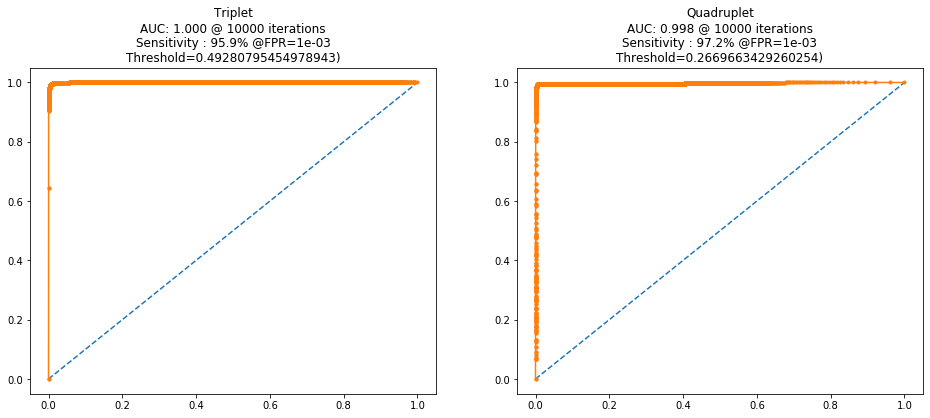

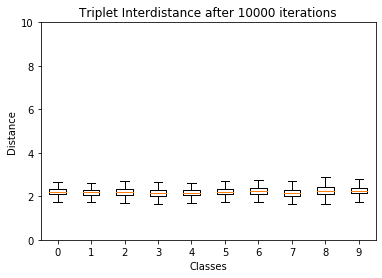

Computing learned distance done                                  


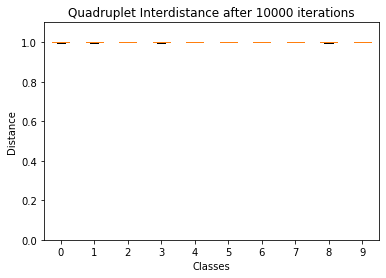

Evaluation time : {} min 60.33430322408676


In [30]:
#Full evaluation
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=True)

In [ ]:
def DisplayFeatureMaps(network,n, name):
    # retrieve weights from the second hidden layer
    filters, biases = network.layers[0].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = n, 1
    
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, 4, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    wandb.log({name:plt})
    plt.show()
DisplayFeatureMaps(network3,4, "CNN Filters 3xLoss")
DisplayFeatureMaps(network4,4, "CNN Filters 4xLoss")

Reloading probs3x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=test, 
Reloading probs3x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=train, 
Reloading probs4x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=test, 
Reloading probs4x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=train, 
Reloading metric3x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=test, 
Reloading metric3x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=train, 
Reloading metric4x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=test, 
Reloading metric4x for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, dataset=train, 


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Reloading interdist_Triplet (Train) for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, 


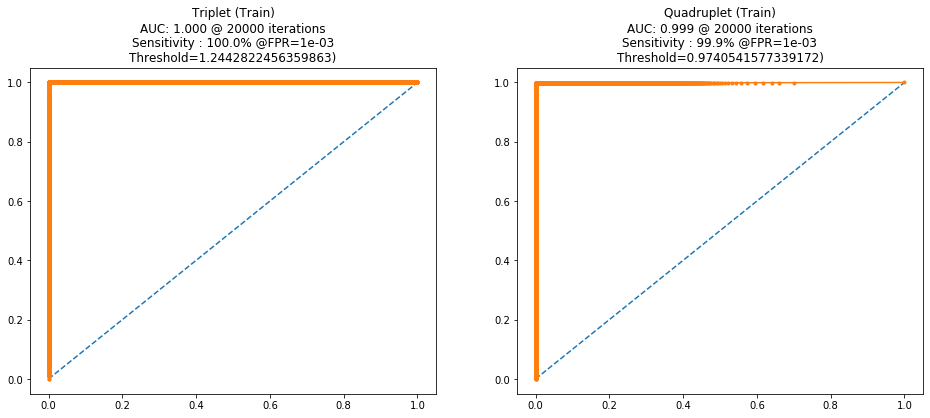

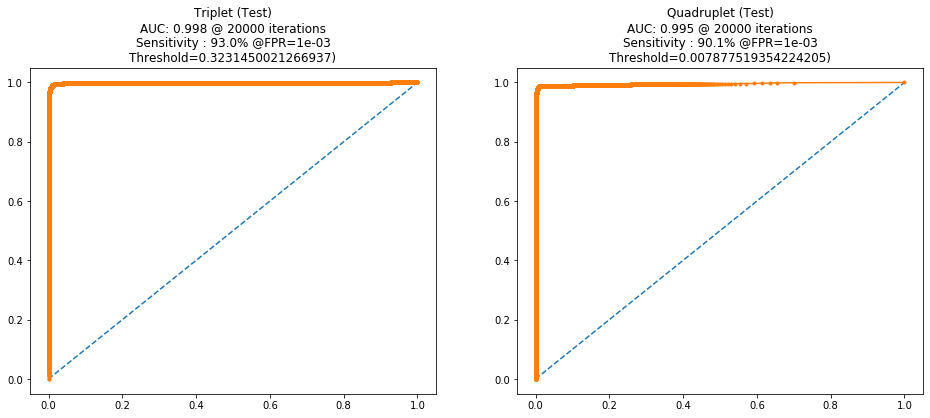

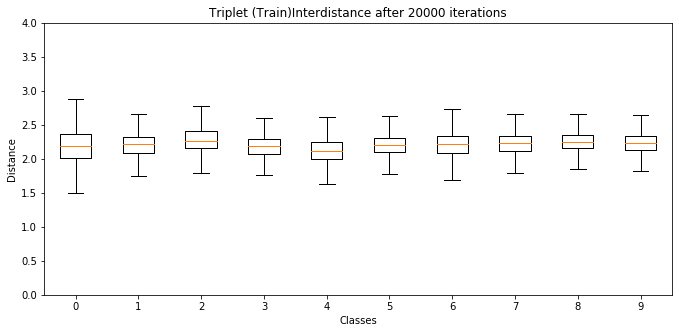

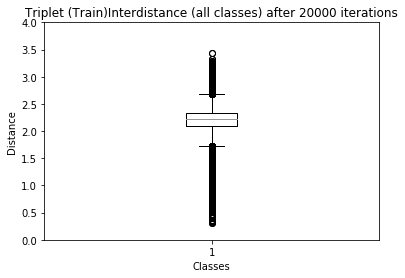

Computing interdist_Quadruplet (Train) for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, 
Computing learned distance done                                  


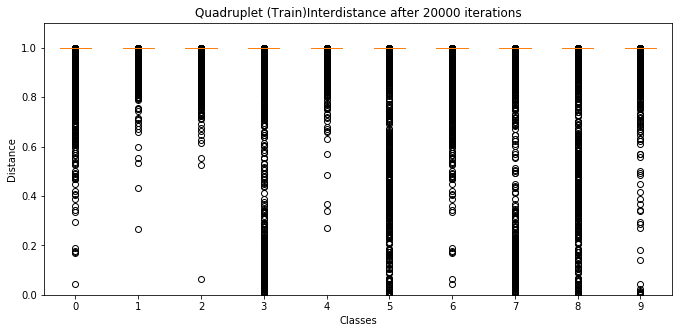

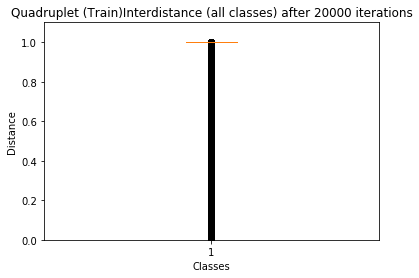

Computing interdist_Triplet (Test) for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, 
Computing L2 distance done                                                       


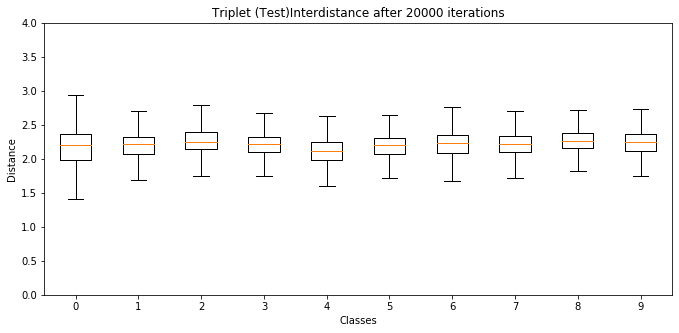

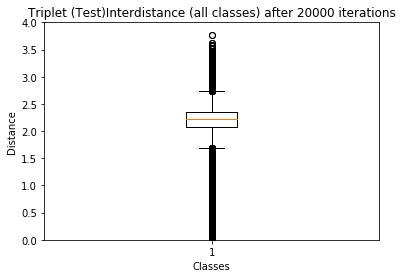

Computing interdist_Quadruplet (Test) for n_iteration=20000, interdistnbclass=10, interdistnbsample=300, 


In [ ]:
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=False)

Computing cmc3x for n_iteration=20000, nb_test_class=10, 
Computing cmc4x for n_iteration=20000, nb_test_class=10, 
Computing cmc3xtrain for n_iteration=20000, nb_test_class=10, 
Computing cmc4xtrain for n_iteration=20000, nb_test_class=10, 


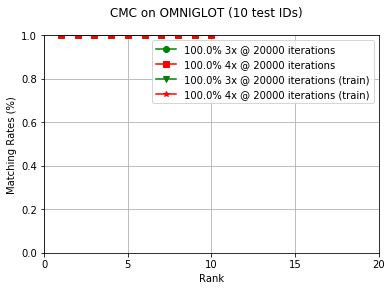

In [20]:
compute_CMC_scores()